# Import

In [20]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Data

In [21]:
video_directory_name = "Videos"
video_name = "cat1.mp4"
video_path = os.path.join(video_directory_name, video_name)

output_directory_name = "Output"
if not os.path.exists(output_directory_name):
    os.makedirs(output_directory_name)

In [22]:
print(video_path)
print(os.path.exists(video_path))

Videos\cat1.mp4
True


# Optical Flow Functions


## Lucas-Kanade

In [27]:
def process_video_with_optical_flow(video_path, output_directory_path, 
                                    max_point_age=20, 
                                    feature_refresh_interval=5, 
                                    max_trail_length=20, 
                                    feature_params=None, lk_params=None):
    """
    Process the input video and apply optical flow annotation, saving the result to the specified output video path.
    
    Args:
        video_path (str): Path to the input video file.
        output_directory_path (str): Directory to save the annotated output video.
        max_point_age (int): Maximum lifespan of a tracked point (in frames).
        feature_refresh_interval (int): Interval (in frames) to detect new features.
        max_trail_length (int): Maximum lifespan of trails in the visualization (in frames).
        feature_params (dict, optional): Parameters for ShiTomasi corner detection.
        lk_params (dict, optional): Parameters for Lucas-Kanade optical flow.
    """
    # Open the video file
    cap = cv.VideoCapture(video_path)

    # Get the video frame width, height, and frame rate to set up the VideoWriter
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)

    # Extract the filename from the video path and append '_output_lucas-kanade.mp4'
    video_filename = os.path.basename(video_path)
    output_video_path = os.path.join(output_directory_path, f"{os.path.splitext(video_filename)[0]}_output_lucas-kanade.mp4")

    # Create VideoWriter to save the output video
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    out = cv.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Default parameters for ShiTomasi corner detection if not provided
    if feature_params is None:
        feature_params = dict(maxCorners=100,
                              qualityLevel=0.3,
                              minDistance=7,
                              blockSize=7)

    # Default parameters for Lucas-Kanade optical flow if not provided
    if lk_params is None:
        lk_params = dict(winSize=(21, 21),
                         maxLevel=3,
                         criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors for visualization
    color = np.random.randint(0, 255, (100, 3))

    # Take the first frame and find corners in it
    ret, old_frame = cap.read()
    if not ret:
        print("Error: Couldn't read the first frame.")
        cap.release()
        out.release()
        return

    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    # Create a list to store recent masks for drawing trails
    recent_masks = []

    # Initialize lifespan tracker for each point
    point_age = [0] * len(p0)

    frame_counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        if p0 is None or len(p0) == 0:
            print("No points to track. Detecting new features...")
            p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            if p0 is None:
                print("No features detected. Skipping frame.")
                old_gray = frame_gray.copy()
                continue

        # Calculate optical flow using Lucas-Kanade method
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Update point ages and filter points that exceed max_point_age
            updated_point_age = []
            new_points = []
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                if point_age[i] < max_point_age:
                    updated_point_age.append(point_age[i] + 1)
                    new_points.append((new, old))
            point_age = updated_point_age
            good_new, good_old = zip(*new_points) if new_points else ([], [])

        if len(good_new) == 0:
            print("No valid points to track. Refreshing features...")
            p0 = cv.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
            point_age = [0] * len(p0) if p0 is not None else []
            old_gray = frame_gray.copy()
            continue

        # Create a temporary mask for the current frame
        current_mask = np.zeros_like(frame)

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            current_mask = cv.line(current_mask, (int(a), int(b)), (int(c), int(d)), color[i % len(color)].tolist(), 2)

        # Add the current mask to the list of recent masks
        recent_masks.append(current_mask)
        if len(recent_masks) > max_trail_length:
            recent_masks.pop(0)

        # Combine recent masks to create the visualization
        combined_mask = sum(recent_masks).clip(0, 255).astype(np.uint8)

        # Overlay the mask on the current frame
        img = cv.addWeighted(frame, 1, combined_mask, 0.5, 0)

        # Write the frame with annotations to the output video
        out.write(img)

        # Update the previous frame and points
        old_gray = frame_gray.copy()
        p0 = np.array(good_new).reshape(-1, 1, 2)

        # Refresh features periodically or when points are low
        frame_counter += 1
        if frame_counter % feature_refresh_interval == 0 or len(p0) < 10:
            new_features = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            if new_features is not None:
                p0 = np.vstack([p0, new_features])
                point_age.extend([0] * len(new_features))

    # Release resources
    cap.release()
    out.release()

    # Indicate that the video has been saved
    print(f"Annotated video saved at: {output_video_path}")


## Farneback

In [28]:
def process_video_with_optical_flow_farneback(video_path, output_directory_path, 
                                              flow_params=None):
    """
    Process the input video and apply Farneback optical flow annotation, saving the result to the specified output video path.
    
    Args:
        video_path (str): Path to the input video file.
        output_directory_path (str): Directory to save the annotated output video.
        flow_params (dict, optional): Parameters for Farneback optical flow.
    """
    # Open the video file
    cap = cv.VideoCapture(video_path)

    # Get the video frame width, height, and frame rate to set up the VideoWriter
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)

    # Extract the filename from the video path and append '_output_farneback.mp4'
    video_filename = os.path.basename(video_path)
    output_video_path = os.path.join(output_directory_path, f"{os.path.splitext(video_filename)[0]}_output_farneback.mp4")

    # Create VideoWriter to save the output video
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    out = cv.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Default parameters for Farneback optical flow if not provided
    if flow_params is None:
        flow_params = dict(pyr_scale=0.5,
                           levels=3,
                           winsize=15,
                           iterations=3,
                           poly_n=5,
                           poly_sigma=1.2,
                           flags=0)

    # Create some random colors for visualization
    hsv = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
    hsv[..., 1] = 255  # Set saturation to max to display the flow

    # Take the first frame and convert to grayscale
    ret, old_frame = cap.read()
    if not ret:
        print("Error: Couldn't read the first frame.")
        cap.release()
        out.release()
        return

    prev_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

    # Set up the plotting (interactive mode for Matplotlib)
    plt.ion()  # Turn on interactive mode

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Calculate optical flow using Farneback
        flow = cv.calcOpticalFlowFarneback(prev_gray, gray, None, **flow_params)
        
        # Convert flow to magnitude and angle
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])

        # Visualize the flow by setting HSV values
        hsv[..., 0] = ang * 180 / np.pi / 2  # Hue represents the direction of flow
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)  # Value represents the magnitude

        # Convert HSV to BGR for display
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

        # Write the frame with annotations to the output video
        out.write(bgr)

        # Update the previous frame
        prev_gray = gray.copy()

    # Release resources
    cap.release()
    out.release()

    # Turn off interactive mode
    plt.ioff()

    # Indicate that the video has been saved
    print(f"Annotated video saved at: {output_video_path}")

# Main


## Lucas-Kanade

In [29]:
feature_params = dict(maxCorners=200,
                        qualityLevel=0.2,
                        minDistance=7,
                        blockSize=7)

lk_params = dict(winSize=(21, 21),
                    maxLevel=3,
                    criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

In [30]:
# Call the function
process_video_with_optical_flow(video_path= video_path,
                                 output_directory_path=output_directory_name,
                                 feature_params=feature_params,
                                 lk_params=lk_params)

No valid points to track. Refreshing features...
Annotated video saved at: Output\cat1_output_lucas-kanade.mp4


## Farneback

In [94]:
# Flow parameters for Farneback optical flow
flow_params = dict(pyr_scale=0.5,
                   levels=3,
                   winsize=15,
                   iterations=3,
                   poly_n=5,
                   poly_sigma=1.2,
                   flags=0)


In [95]:
# Call the function
process_video_with_optical_flow_farneback(video_path=video_path,
                                          output_directory_path=output_directory_name,
                                          flow_params=flow_params)


Annotated video saved at: Output\herisson_output_farneback.mp4


# Scene Detect

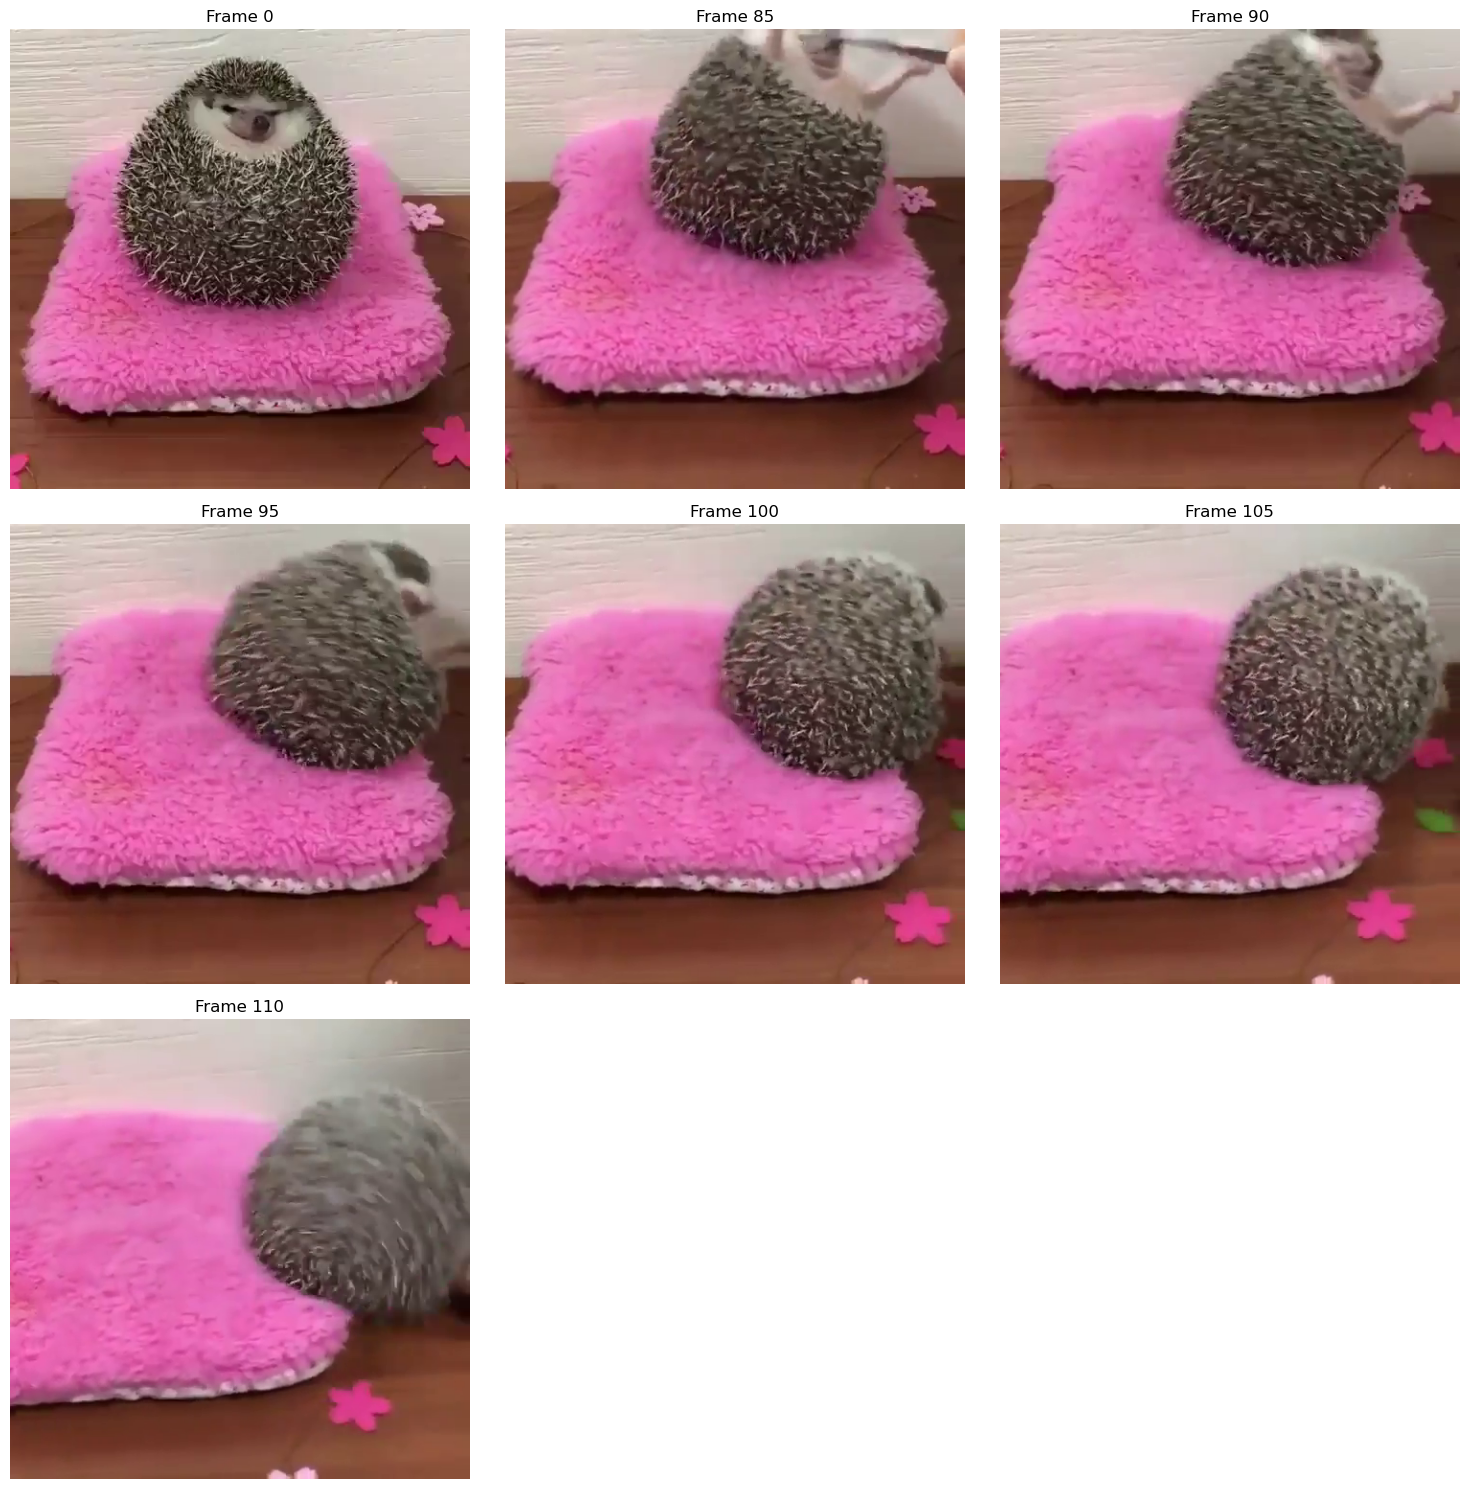

In [98]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def detect_scene_changes(video_path, 
                         feature_params=None, 
                         lk_params=None, 
                         motion_threshold=50, 
                         min_frame_gap=5):
    """
    Detect scene changes in a video using Lucas-Kanade optical flow.
    
    Args:
        video_path (str): Path to the input video file.
        feature_params (dict, optional): Parameters for ShiTomasi corner detection.
        lk_params (dict, optional): Parameters for Lucas-Kanade optical flow.
        motion_threshold (float): Threshold for total motion to consider a scene change.
        min_frame_gap (int): Minimum number of frames between two scene changes.
    
    Returns:
        List of tuples: Each tuple contains the frame index and the corresponding frame image at scene changes.
    """
    # Open the video file
    cap = cv.VideoCapture(video_path)

    # Default parameters for ShiTomasi corner detection if not provided
    if feature_params is None:
        feature_params = dict(maxCorners=100,
                              qualityLevel=0.3,
                              minDistance=7,
                              blockSize=7)

    # Default parameters for Lucas-Kanade optical flow if not provided
    if lk_params is None:
        lk_params = dict(winSize=(21, 21),
                         maxLevel=3,
                         criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # Take the first frame and find corners in it
    ret, old_frame = cap.read()
    if not ret:
        print("Error: Couldn't read the first frame.")
        cap.release()
        return []

    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    scene_changes = [(0, old_frame)]  # Store the first frame as the initial scene
    frame_counter = 0
    last_scene_frame = 0  # Track the last scene change frame

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None and p0 is not None:
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Compute total motion (sum of Euclidean distances)
            motion = np.sum(np.linalg.norm(good_new - good_old, axis=1))

            # Detect a scene change if motion exceeds the threshold and frame gap is respected
            if motion > motion_threshold and (frame_counter - last_scene_frame) >= min_frame_gap:
                scene_changes.append((frame_counter, frame))
                last_scene_frame = frame_counter  # Update the last scene change frame

        # Update the previous frame and points
        old_gray = frame_gray.copy()
        p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params) if p1 is None else good_new.reshape(-1, 1, 2)

        frame_counter += 1

    cap.release()
    return scene_changes


def plot_scene_changes(scene_changes, cols=3):
    """
    Plot detected scene changes using matplotlib.
    
    Args:
        scene_changes (list): List of tuples containing frame index and images of the scenes.
        cols (int): Number of columns for the plot grid.
    """
    num_scenes = len(scene_changes)
    rows = (num_scenes + cols - 1) // cols  # Calculate rows based on total scenes and columns

    plt.figure(figsize=(15, rows * 5))
    for i, (frame_idx, frame) in enumerate(scene_changes):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Usage Example
scene_changes = detect_scene_changes(video_path, motion_threshold=600, min_frame_gap=5)
plot_scene_changes(scene_changes, cols=3)
